In [150]:
#pip install Clustimage
#pip install tensorflow
#pip install keras

SyntaxError: invalid syntax (3540094311.py, line 2)

In [1]:
from clustimage import Clustimage
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import numpy as np
from PIL import Image
from scipy.ndimage import median_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import maximum_filter
from matplotlib import cm
from collections import OrderedDict

In [2]:
#Defino funciones:

#Funcion para leer los archivos, lee ".png" por defecto
def leer_img(img_path,formato=".png"):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path

#Funcion para verificar que los archivos sean todos del mismo tamaño (tamaño por defecto 128,128,3)
def ver_tam(ubicacion, size=(128,128,3),max=255):
  '''Función para verificar el tamaño de los archivos
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  size(tupla, por defecto 128,128,3) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).shape != size]
  if diferentes == []:
    print("Los tamaños son: ", size)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).shape)
    return diferentes

def r_max_min(ubicacion, rango=[0,255]): #Revisar esto y sumar max y min para que sea univoco
  '''Función para verificar el el valor máximo de las matrices
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  max(int, por defecto 255) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).max() > max(rango) or cv2.imread(x).min() < min(rango) ]
  if diferentes == []:
    print("El valor máximo es menor o igual: ", rango)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).min(), cv2.imread(dife).max())
    return diferentes

In [3]:
dir_path = "C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img"

In [4]:
def leer_nimg(img_path,formato=".png",n=100):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''  
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  largo = len(path)
  if n<largo:
      path = path[:n]
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path


completo = []
for ct,directorio in enumerate(os.listdir(dir_path)):           
    path = leer_nimg(dir_path+"\\"+directorio,".jpg",1000)
    completo += path



Numero de imagenes cargadas:  1000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Arborio\Arborio (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Basmati\Basmati (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Ipsala\Ipsala (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Jasmine\Jasmine (1).jpg
Numero de imagenes cargadas:  1000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Karacadag\Karacadag (1).jpg


In [5]:
completo

['C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (1).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (10).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (100).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (1000).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (10000).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (10001).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (10002).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (10003).jpg',
 'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\

In [22]:
#Verificamos el tamño de las imagenes
size = (250,250,3)
diferentes = ver_tam(completo,size)
#Verificamos el si los valores se encuentran en rango
#ranguera = [0,255]
#max_val = r_max_min(path,ranguera)

Los tamaños son:  (250, 250, 3)


In [6]:
tipos = ["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

para_labels = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels += temp*1000


In [7]:
df_paths = pd.DataFrame(completo)

In [8]:
df_paths = df_paths.rename(columns={0:"ubica"}) 
df_paths["file"] = df_paths["ubica"].str.split('\\').str.get(-1)

In [9]:
df_paths["label"] = para_labels
df_combi = df_paths

In [141]:
tipos = ["0","1","2","3","4"]

para_labels_num = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels_num += temp*1000
    
df_combi["label_num"] = para_labels_num

df_combi["label_num"] = df_combi["label_num"].astype('int64')

df_combi

,ubica,file,label,predicted,label_num
0,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1).jpg,Arborio,3,0
1,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10).jpg,Arborio,4,0
2,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (100).jpg,Arborio,1,0
3,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1000).jpg,Arborio,3,0
4,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10000).jpg,Arborio,0,0
...,...,...,...,...,...
4995,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10894).jpg,Karacadag,3,4
4996,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10895).jpg,Karacadag,3,4
4997,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10896).jpg,Karacadag,0,4
4998,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10897).jpg,Karacadag,3,4


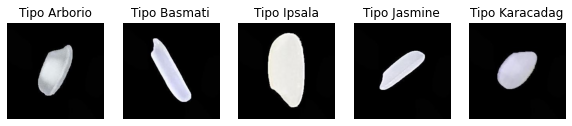

In [11]:
fig, axs = plt.subplots(1,5, figsize=(10, 10))
for ct,i in enumerate(df_combi["label"].unique()):
  testeo = df_combi[df_combi.label == i]
  ubica = testeo.sample().ubica.iloc[0]
  img = Image.open(ubica)
  axs[ct].imshow(img)
  axs[ct].set_title(f'Tipo {i}')
  axs[ct].axis('off')
#fig.tight_layout(h_pad=-20, w_pad=1)

In [12]:
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd

In [13]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [14]:
def preprocess(lista, model):
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress
    # lista de filenames
    filenmss = np.array(list(datays.keys()))

    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens
    print(featsss.shape)
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

def extract_features(file, model):
    # levanta imagen como array 224x224
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image')
    img = np.array(img)
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [15]:
names, feat = preprocess(completo, model)

1/1 [==============================] - 0s 93ms/step
(5000, 1, 4096)


In [16]:
# get the unique labels (from the flower_labels.csv)

label = df_combi['label'].tolist()
unique_labels = list(set(label))
unique_labels

['Ipsala', 'Arborio', 'Basmati', 'Karacadag', 'Jasmine']

In [17]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [18]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


Components before PCA: 4096
Components after PCA: 100


In [19]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=5)
kmeans.fit(x)

KMeans(n_clusters=5)

In [20]:
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

Clipping cluster size from 1094 to 10
Clipping cluster size from 969 to 10
Clipping cluster size from 1063 to 10
Clipping cluster size from 1022 to 10
Clipping cluster size from 852 to 10


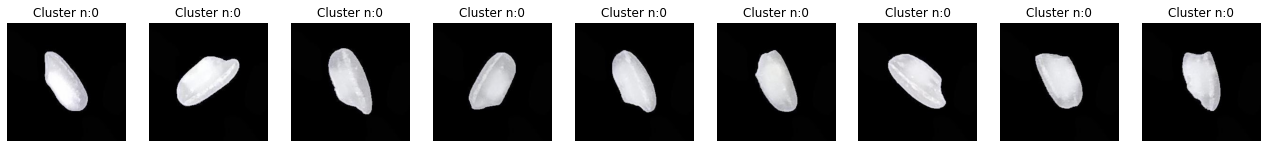

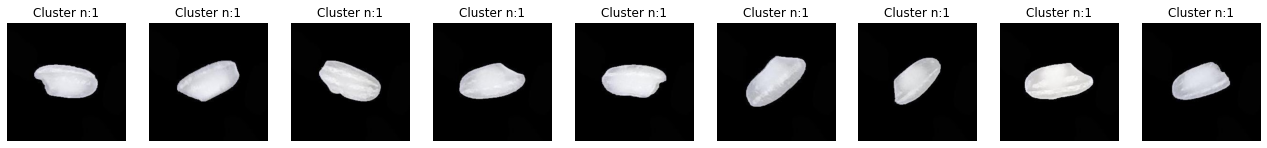

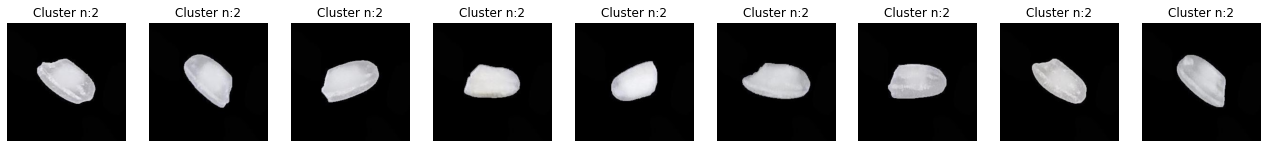

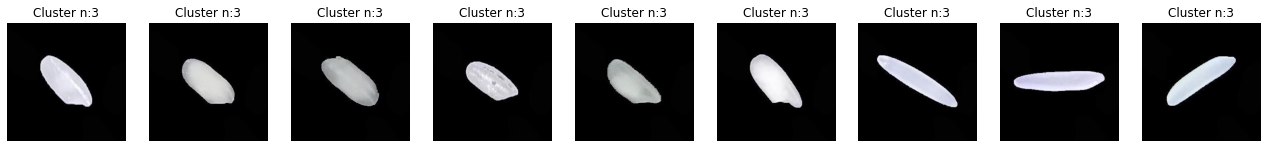

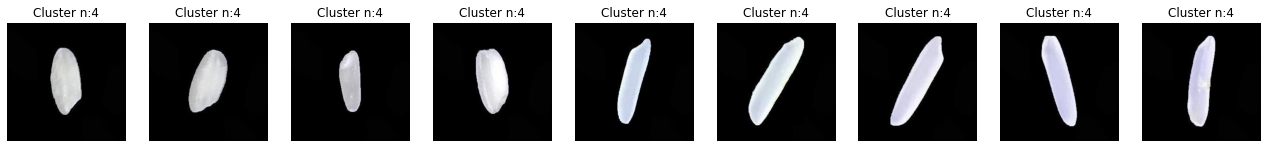

In [21]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

Text(0, 0.5, 'PC4')

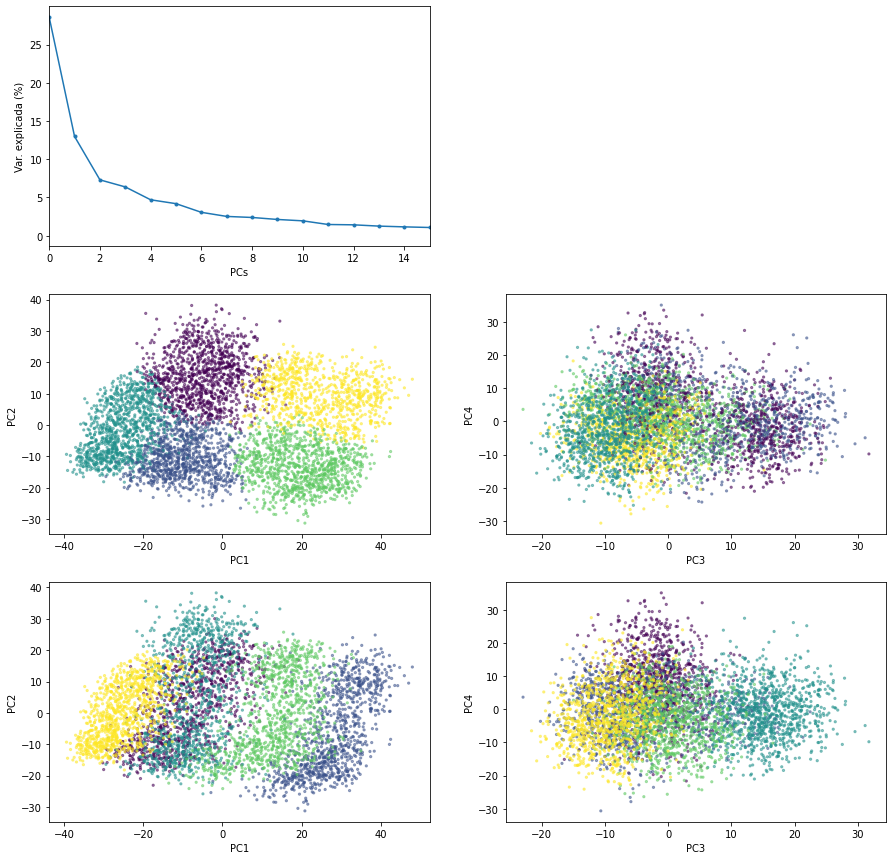

In [140]:
fig, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
axs[0,0].set_xlim([0,15])
axs[0,0].set_xlabel('PCs')
axs[0,0].set_ylabel('Var. explicada (%)')
axs[0,1].axis('off')

axs[1,0].scatter(x[:,0],x[:,1],s=5,c=kmeans.labels_, alpha=0.5)
axs[1,0].set_xlabel('PC1')
axs[1,0].set_ylabel('PC2')
axs[1,1].scatter(x[:,2],x[:,3],s=5,c=kmeans.labels_, alpha=0.5)
axs[1,1].set_xlabel('PC3')
axs[1,1].set_ylabel('PC4')
axs[2,0].scatter(x[:,0],x[:,1],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,0].set_xlabel('PC1')
axs[2,0].set_ylabel('PC2')
axs[2,1].scatter(x[:,2],x[:,3],s=5,c=df_combi["label_num"], alpha=0.5)
axs[2,1].set_xlabel('PC3')
axs[2,1].set_ylabel('PC4')

In [24]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score

     ------------------------------------- 343.0/343.0 kB 20.8 MB/s eta 0:00:00


In [27]:
# Acá arrancan los cambios
KM_meta=KMedoids(n_clusters=5,init='k-medoids++').fit(x)

In [100]:
def sum_sse(KM):
  sse = 0  
  sse = (KM.inertia_)
  return sse

In [105]:
print(KM_meta.labels_)
print(KM_meta.medoid_indices_)
print(silhouette_score(x,KM_meta.labels_))
print(sum_sse(KM_meta))
silhouette_samples(x,KM_meta.labels_)

[14 17 19 ... 15  9 17]
[4154 2323 4666 1497  665 1165  270 1410 3748 4028 2456 3219 3135 2047
  301 4536 1058 4086 3025  195 3299  695 2479 3492]
0.06402238
139754.67


array([ 0.14510965,  0.01269726,  0.12172116, ..., -0.04289958,
        0.16171804, -0.14391172], dtype=float32)

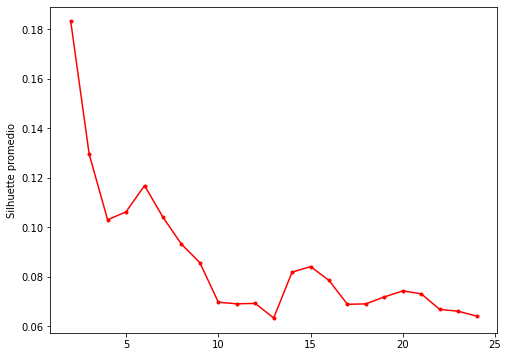

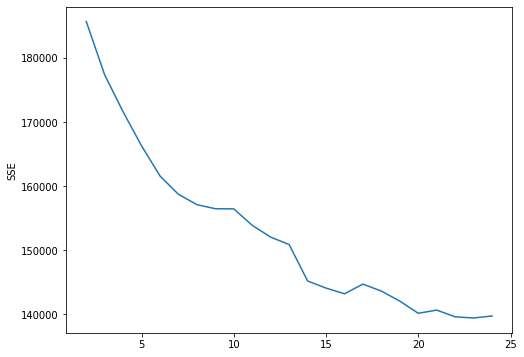

[185683.11, 177355.9, 171581.28, 166280.69, 161582.08, 158723.19, 157113.17, 156480.1, 156455.75, 153886.44, 152044.83, 150896.36, 145215.97, 144101.31, 143212.94, 144720.27, 143638.27, 142068.17, 140173.56, 140671.4, 139620.4, 139442.44, 139754.67]


In [104]:
range_k = range(2,25)
silh = []
sse = []
for k in range_k:    
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    KM_meta = KMedoids(n_clusters=k,init='heuristic').fit(x) 
    silh.append(silhouette_score(x,KM_meta.labels_))
    sse.append(sum_sse(KM_meta))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse)
plt.ylabel('SSE')
plt.show()

print(sse)


In [35]:
import matplotlib.cm as cm

def grafica_silhouette(KM,d):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title(("Silhouette analysis for KMeans clustering on sample data "
                "with k = %d" % k),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

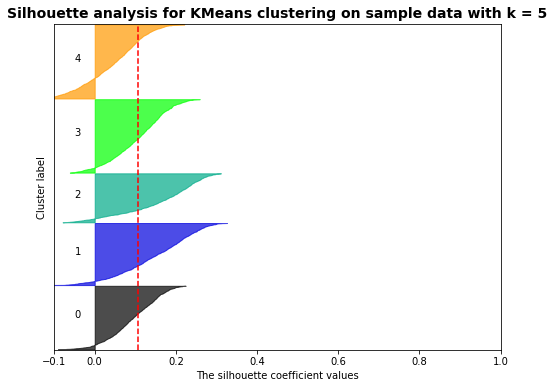

In [106]:
k = 5
KM_meta = KMedoids(n_clusters=k,metric='euclidean',init='heuristic').fit(x)
grafica_silhouette(KM_meta,x)

In [110]:
df_combi[999:1001]

,ubica,file,label
999,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10898).jpg,Arborio
1000,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Basmati (1).jpg,Basmati


In [114]:
df_combi["predicted"] = KM_meta.labels_

In [134]:
df_combi

,ubica,file,label,predicted,label_num
0,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1).jpg,Arborio,3,0
1,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10).jpg,Arborio,4,0
2,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (100).jpg,Arborio,1,0
3,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1000).jpg,Arborio,3,0
4,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10000).jpg,Arborio,0,0
...,...,...,...,...,...
4995,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10894).jpg,Karacadag,3,4
4996,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10895).jpg,Karacadag,3,4
4997,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10896).jpg,Karacadag,0,4
4998,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (10897).jpg,Karacadag,3,4


In [135]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(df_combi["label_num"],df_combi["predicted"])

0.31172431080595114

In [136]:
#función definida 
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [138]:
#vanDongen 
df_van = df_combi[["label_num","predicted"]]
vanDongen(df_van)

0.866631696282211